<a href="https://colab.research.google.com/github/songiangvn/AI-Machine-Learning-for-Coders/blob/main/Chapter_3_3_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 3: Going Beyond the Basics: Detecting Features in Images - Transfer Learning

Ý tưởng chính: Sử dụng một mô hình đã được train trước đó(pretrained) với much larger dataset. Sau đó kết hợp với mô hình để phù hợp với bài toán của mình. Từ đó học được nhiều hơn và đưa ra kết quả tốt hơn

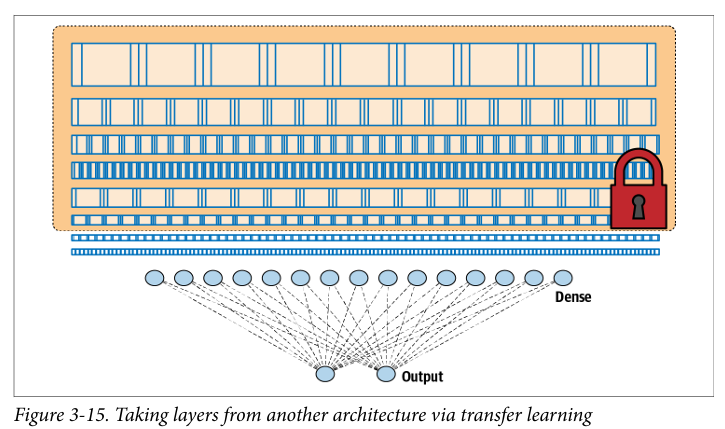

Về cách triển khai, ở trong mô hình dưới đây, chúng ta sẽ thực hiện theo kiểu tận dụng kiến trúc và trọng số của mô hình có sẵn, kết hợp thêm với các lớp tuyến tính do chúng ta định nghĩa để thu được đầu ra cuối cùng.

- **Các lớp lấy từ mô hình có sẵn**: Chúng ta sẽ không huấn luyện chúng mà **đóng băng** hoặc **khóa** lại, nghĩa là khi huấn luyện, trọng số trong các lớp của mô hình có sẵn sẽ không thay đổi nữa.
- **Các lớp tuyến tính định nghĩa thêm**: Chúng sẽ được huấn luyện, thay đổi và cập nhật trọng số trong suốt quá trình học.

> Note: When we consider that, once they’ve been trained, all these layers are just a set of
 numbers indicating the filter values, weights, and biases along with a known architec
ture (number of filters per layer, size of filter, etc.), the idea of reusing them is pretty
 straightforward.

## Triển khai mô hình - Ví dụ Inception version 3

We’ll use version 3 of the popular Incep
tion model from Google, which is trained on more than a million images from a data
base called ImageNet. It has dozens of layers and can classify images into one
 thousand categories.

In [4]:
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Tải trọng số  hay kiến thức học được của mô hình.
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"

urllib.request.urlretrieve(weights_url, weights_file)

('inception_v3.h5', <http.client.HTTPMessage at 0x7923066c3dd0>)

- urllib.request là cái sẽ dùng khi mà cần dùng những cái lấy từ url nào đó

In [18]:
# Khởi tạo mô hình InceptionV3 và nạp trọng số vào cho mô hình
# Ở đây trong sách để kích thước là 150 x 150 nha, nhưng khi mình huấn luyện với bộ horse-or-human
# mình thấy kích thước 300 x 300 mới huấn luyện được nên đổi lại.
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(weights_file)

In [6]:
# Xem qua kiến trúc của mô hình.
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 300, 300, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Khi sử dụng một mô hình đã được pretrained thì hãy đọc cái summary của nó về các layer để xem mình sẽ trích suất và sử dụng output từ layer nào của mô hình đó.

## Trích xuất, chọn lớp từ mô hình có sẵn

Tác giả trong sách đề xuất ouput từ layer mixed7, vì output của nó tốt và nhỏ - kích thước 7x7 images. Tuy nhiên vẫn có thể thử sử dụng output từ các layer khác

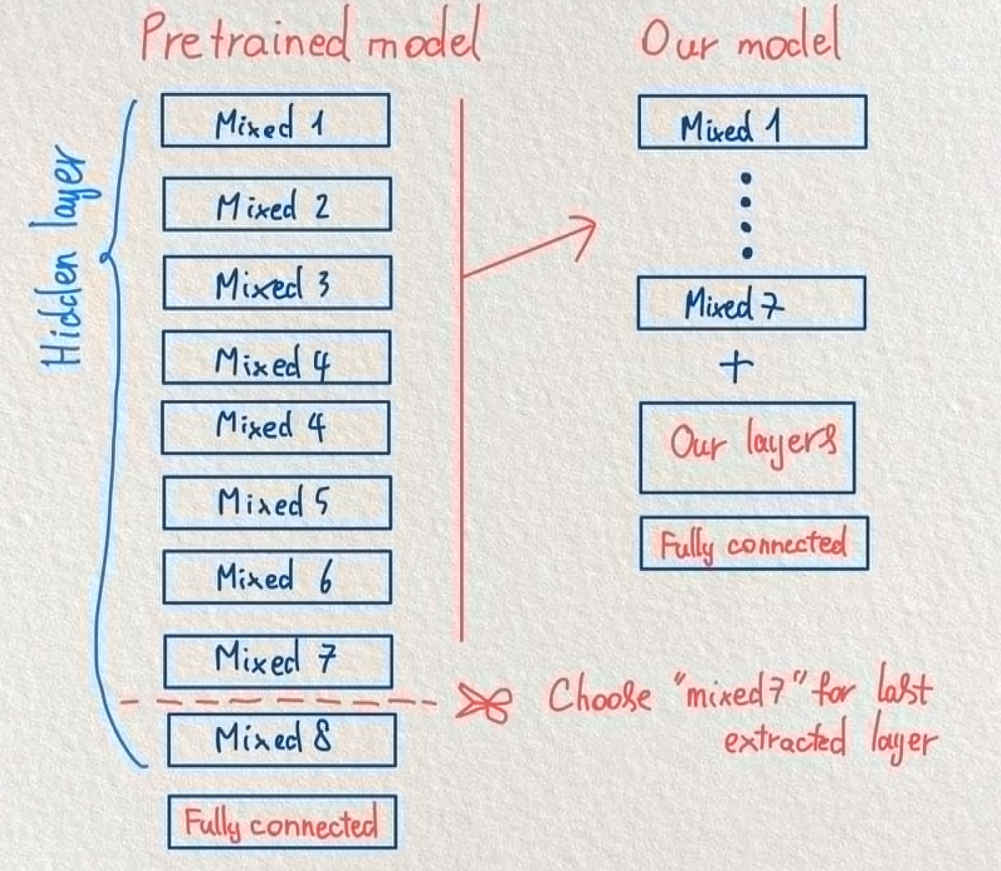

Sau khi chọn được vị trí layer mà ta tiến hành trích xuất output đầu ra, ta sẽ tiến hành "đóng băng tất cả các lớp của mô hình InceptionV3", không cho chúng học trong quá trình huấn luyện

In [19]:
# Tiến hành đóng băng các lớp của mô hình InceptionV3
for layer in pre_trained_model.layers:
    layer.trainable = False

# Chọn lớp trích xuất đầu ra cuối
last_layer = pre_trained_model.get_layer('mixed7')
print(f"Kích thước đầu ra của lớp đã chọn: {last_layer.output.shape}")

# Định nghĩa đầu ra cuối cùng
last_output = last_layer.output

Kích thước đầu ra của lớp đã chọn: (None, 7, 7, 768)


In [20]:
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Trải phẳng hình ảnh hay ma trận đặc trưng thu được từ việc trích xuất lớp cuối để đưa vào lớp tuyến tính
x = Flatten()(last_output)
# Thêm các lớp tuyến tính vào và cho dữ liệu thu được (x) đi qua
x = Dense(1024, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

Vậy là hoàn thành quá trình chuẩn bị rồi, bây giờ tụi mình khởi tạo mô hình với đầu vào là của mô hình được huấn luyện sẵn **(InceptionV3)** và **kiến trúc x** (quá trình đi qua các lớp) mà chúng ta đã định nghĩa ở trên nha.

In [21]:
from tensorflow.keras.optimizers import RMSprop
# Khởi tạo mô hình
model = Model(pre_trained_model.input, x)

# Định nghĩa các tham số
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

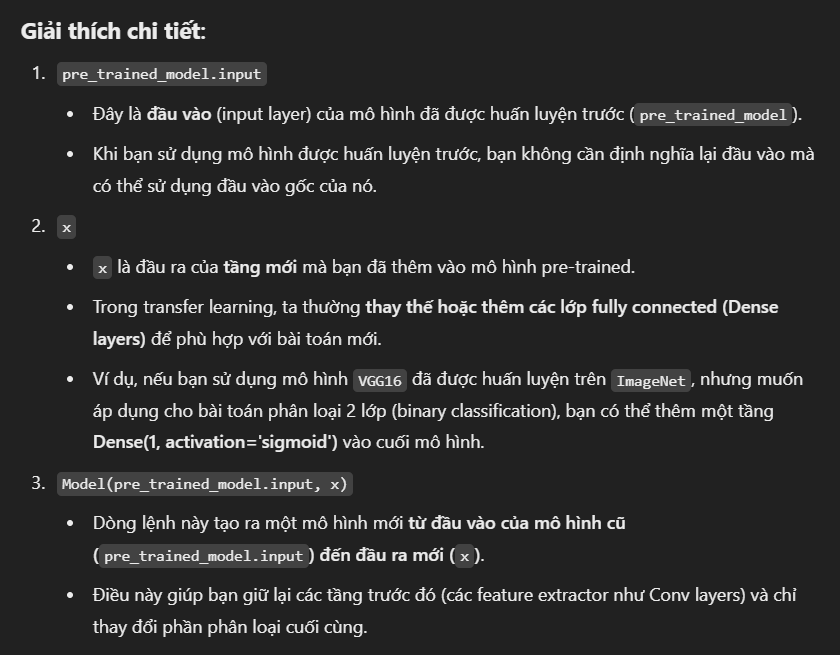

Tóm lại: Dùng Model(pre_trained_model.input, x) giúp tạo một mô hình mới dựa trên đầu vào của mô hình cũ nhưng với đầu ra tùy chỉnh.

# Dùng Mô hình Transfer learning cho bài toán Horse or Human kết hợp với Image Augementation

In [10]:
import urllib.request
import zipfile

# Link để download bộ dữ liệu huấn luyện horse-or-human
url = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"

file_name = "horse-or-human.zip"
training_dir = "horse-or-human/training/"
urllib.request.urlretrieve(url, file_name)

# Giải nén file zip
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40, # Xoay ngẫu nhiên từ 0 đến 40 độ qua trái hoặc phải
    width_shift_range = 0.2, # Dịch hình ảnh qua trái hoặc phải từ 0 đến 20%
    height_shift_range = 0.2, # Dịch hình ảnh lên xuống từ 0 đến 20%
    shear_range = 0.2, # Cắt nghiên hình ảnh từ 0 đến 20%
    zoom_range = 0.2, # Phóng to, thu nhỏ hình ảnh ngẫu nhiên từ 0 đến 20%
    horizontal_flip = True, # Lật ngang hình ảnh
    fill_mode = 'nearest' # Các pixel mới được tạo ra dựa trên cấc pixel gần nhất
)

Create Training Set

In [22]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(150, 150),
    class_mode='binary'
)

Found 1027 images belonging to 2 classes.


Create Validation Set

In [23]:
# Tải bộ dữ liệu hiệu chỉnh (validation)
url = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
validation_dir = 'horse-or-human/validation/'
urllib.request.urlretrieve(url, validation_file_name)

zip_ref = zipfile.ZipFile(validation_file_name, 'r')
zip_ref.extractall(validation_dir)
zip_ref.close()

validation_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    class_mode='binary'
)

Found 256 images belonging to 2 classes.


Dùng model đã xây dựng dựa trên InceptionV3 ở trên

In [24]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data = validation_generator
)

Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 637ms/step - acc: 0.8221 - loss: 0.4973 - val_acc: 0.9688 - val_loss: 0.0639
Epoch 2/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 366ms/step - acc: 0.9807 - loss: 0.0401 - val_acc: 0.9727 - val_loss: 0.0681
Epoch 3/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 357ms/step - acc: 0.9883 - loss: 0.0316 - val_acc: 0.9883 - val_loss: 0.0245
Epoch 4/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - acc: 0.9909 - loss: 0.0219 - val_acc: 0.9922 - val_loss: 0.0087
Epoch 5/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 335ms/step - acc: 0.9957 - loss: 0.0125 - val_acc: 0.9961 - val_loss: 0.0069
Epoch 6/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 354ms/step - acc: 0.9925 - loss: 0.0134 - val_acc: 0.9922 - val_loss: 0.0228
Epoch 7/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 385ms/step - acc: 0.9998 - loss: 0.0029 - val_acc: 0.9336 - val_loss: 0.2421
Epoch 8/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step - acc: 0.9893 - loss: 0.0176 - val_acc: 0.9961 - val_loss: 0.0080
Epoch 9/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/

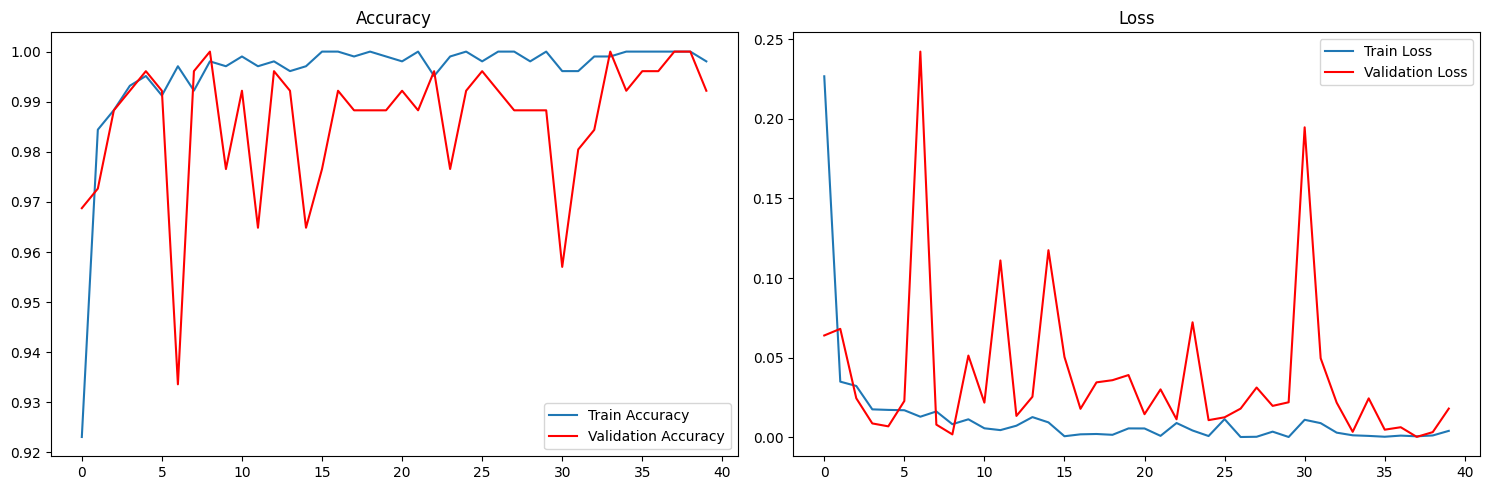

In [25]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ đánh giá quá trình train trên 15 epochs
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(acc, label='Train Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy', color = 'red')
axs[0].set_title('Accuracy')
axs[0].legend()
axs[1].plot(loss, label='Train Loss')
axs[1].plot(val_loss, label='Validation Loss', color = 'red')
axs[1].set_title('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [26]:
# Kết quả đánh giá trên tập val
result = model.evaluate(validation_generator)
for i,m in enumerate(model.metrics_names):
  print(f"Kết quả đánh giá {m} trên tập val: {result[i]}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - acc: 0.9946 - loss: 0.0144
Kết quả đánh giá loss trên tập val: 0.018047593533992767
Kết quả đánh giá compile_metrics trên tập val: 0.9921875


In [28]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

# Danh sách để lưu kết quả dự đoán
predicted_result = []

uploaded = files.upload()

for fn in uploaded.keys():
  # Lấy đường dẫn hình ảnh
  path = '/content/' + fn

  # Tiến hành lấy dữ liệu hình ảnh
  # Ảnh up lên có thể có nhiều kích thước khác nhau nên mình cần xác định lại về đúng kích thước đầu vào của mô hình (300 x 300).
  img = image.load_img(path, target_size = (150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)

  # Dự đoán hình ảnh
  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  pred_label = 0 if classes[0] < 0.5 else 1

  if pred_label == 1:
    print(f"Kết quả dự đoán {fn} là người.")
  else:
    print(f"Kết quả dự đoán {fn} là ngựa.")

  predicted_result.append([img, pred_label])


Saving horse2.jpg to horse2 (2).jpg
Saving horse1.jpg to horse1 (2).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Kết quả dự đoán horse2 (2).jpg là người.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Kết quả dự đoán horse1 (2).jpg là người.


# **Tổng hợp kiến thức về Transfer Learning**

## **1. Transfer Learning là gì?**
**Transfer Learning (học chuyển giao)** là kỹ thuật trong Machine Learning, trong đó một mô hình đã được huấn luyện trên một nhiệm vụ lớn sẽ được **tái sử dụng** cho một nhiệm vụ khác, thường là một nhiệm vụ có ít dữ liệu hơn.  

Thay vì huấn luyện một mô hình từ đầu (đòi hỏi rất nhiều dữ liệu và thời gian), ta có thể **tận dụng trọng số (weights) của một mô hình đã được huấn luyện trước** trên một tập dữ liệu lớn như **ImageNet**, sau đó tinh chỉnh (fine-tuning) mô hình đó để phù hợp với bài toán của mình.

---

## **2. Khi nào nên sử dụng Transfer Learning?**
- Khi **dữ liệu huấn luyện bị hạn chế** (không đủ để huấn luyện mô hình từ đầu).
- Khi muốn **tăng tốc độ huấn luyện** vì không cần huấn luyện toàn bộ mô hình từ đầu.
- Khi bài toán mới **có đặc điểm tương tự** với bài toán mà mô hình ban đầu đã học (ví dụ: nhận diện hình ảnh của xe cộ dựa trên mô hình huấn luyện từ ImageNet).

---

## **3. Các phương pháp Transfer Learning**
Có 2 phương pháp chính để sử dụng Transfer Learning:

### **3.1. Feature Extraction (Trích xuất đặc trưng)**
- Giữ nguyên **các tầng Convolutional** của mô hình gốc để **trích xuất đặc trưng**.
- Thay thế **các tầng Fully Connected (FC) cuối cùng** để phù hợp với bài toán mới.
- Thường áp dụng khi dữ liệu mới **ít hơn** và **cấu trúc dữ liệu tương tự** với tập dữ liệu ban đầu.

🔹 **Ví dụ: Sử dụng mô hình ResNet50 để phân loại chó/mèo**
```python
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load mô hình ResNet50 đã huấn luyện trước, bỏ phần Fully Connected cuối
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng trọng số của mô hình gốc
for layer in base_model.layers:
    layer.trainable = False

# Thêm tầng mới để phù hợp với bài toán
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

# Tạo mô hình mới
model = Model(base_model.input, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

✅ **Ưu điểm:** Nhanh, ít dữ liệu hơn, tận dụng được đặc trưng mạnh mẽ của mô hình có sẵn.  
⚠️ **Nhược điểm:** Không tối ưu nếu bài toán mới quá khác biệt với bài toán gốc.

---

### **3.2. Fine-tuning (Tinh chỉnh toàn bộ mô hình)**
- Giữ nguyên các tầng ban đầu nhưng **mở khóa một số tầng cuối cùng** để huấn luyện lại trên dữ liệu mới.
- Dùng khi **có nhiều dữ liệu hơn** và muốn mô hình thích nghi tốt hơn với bài toán mới.

🔹 **Ví dụ: Fine-tune VGG16 trên tập dữ liệu mới**
```python
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

# Load mô hình VGG16 và giữ lại các trọng số đã huấn luyện
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Chỉ mở khóa huấn luyện từ tầng thứ 15 trở đi
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

# Thêm các tầng mới
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Tạo mô hình mới
model = Model(base_model.input, x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
```

✅ **Ưu điểm:** Linh hoạt, giúp mô hình học được đặc trưng chuyên biệt hơn.  
⚠️ **Nhược điểm:** Cần nhiều dữ liệu hơn, thời gian huấn luyện lâu hơn.

---

## **4. Các mô hình Pre-trained phổ biến**
Dưới đây là một số mô hình phổ biến đã được huấn luyện trước trên tập dữ liệu ImageNet:

| Mô hình        | Kiến trúc            | Ứng dụng chính |
|---------------|--------------------|--------------|
| VGG16/VGG19   | ConvNet sâu, đơn giản | Nhận diện ảnh, y tế |
| ResNet50/ResNet101 | Residual Network, giảm gradient vanishing | Nhận diện đối tượng, y tế |
| InceptionV3   | Sử dụng nhiều kernel khác nhau | Nhận diện ảnh chi tiết |
| MobileNetV2   | Nhẹ, tối ưu cho mobile | Nhận diện thời gian thực |
| EfficientNet  | Hiệu suất cao, nhẹ | Nhận diện hình ảnh |

👉 **Cách tải mô hình pre-trained**:
```python
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2

resnet = ResNet50(weights='imagenet')
vgg = VGG16(weights='imagenet')
mobilenet = MobileNetV2(weights='imagenet')
```

---

## **5. Transfer Learning cho NLP**
Ngoài hình ảnh, Transfer Learning cũng được áp dụng nhiều trong NLP (Xử lý ngôn ngữ tự nhiên). Các mô hình Pre-trained phổ biến:
- **BERT (Bidirectional Encoder Representations from Transformers)**
- **GPT (Generative Pre-trained Transformer)**
- **Word2Vec, GloVe** (cho embedding từ vựng)

👉 **Ví dụ dùng BERT để phân loại văn bản**:
```python
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
```

---

## **6. Tổng kết**
| Phương pháp          | Đặc điểm chính | Khi nào dùng? |
|---------------------|---------------|-------------|
| **Feature Extraction** | Giữ nguyên các tầng CNN, thay FC layers | Khi có ít dữ liệu |
| **Fine-tuning** | Mở khóa một số tầng, tinh chỉnh lại trọng số | Khi có nhiều dữ liệu hơn |
| **Pre-trained NLP Models** | Dùng BERT, GPT, Word2Vec, v.v. | Khi xử lý văn bản |

💡 **Kết luận:**  
- **Transfer Learning giúp tăng tốc độ huấn luyện và tối ưu mô hình với ít dữ liệu hơn.**
- **Có thể sử dụng Feature Extraction hoặc Fine-tuning tùy vào lượng dữ liệu và bài toán cụ thể.**
- **Các mô hình như VGG16, ResNet, MobileNet, BERT có thể được tái sử dụng cho nhiều nhiệm vụ khác nhau.**

# Mai train lại trên bộ Dogs and Cats xem như nào